In [1]:
import numpy as np
import sqlite3
import pandas as pd
from scipy.spatial import ConvexHull
execfile('Imports.py')
import Modules.Funcs as funcs

#Get generation data
dbname = '../data/experiment.db'#'experiments-pooled.db'#'experiments-5con.db'#raw data
con = sqlite3.connect(dbname)
participants = pd.read_sql_query("SELECT participant, condition from participants", con)
generation = pd.read_sql_query("SELECT * from generation", con)
alphas = pd.read_sql_query("SELECT * from alphas", con)
stimuli = pd.read_sql_query("SELECT * from stimuli", con).values
con.close()
# create categories mapping                                                                             
mapping = pd.DataFrame(columns = ['condition', 'categories'])
for i in alphas.columns:
    As = alphas[i].values.flatten()
    mapping = mapping.append(
        dict(condition = i, categories =[As]),
        ignore_index = True
    )
# merge categories into generation                                                                      
generation = pd.merge(generation, participants, on='participant')
generation = pd.merge(generation, mapping, on='condition')
bcKey = 'BC-'
overlapAll = {'Not-Alpha':0,'Beta':0,'BC-Beta':0,'BC-Gamma':0}
overlapCount = {'Not-Alpha':0,'Beta':0,'BC-Beta':0,'BC-Gamma':0}
overlapList = {'Not-Alpha':[],'Beta':[],'BC-Beta':[],'BC-Gamma':[]}
overlapPpt = {'Not-Alpha':[],'Beta':[],'BC-Beta':[],'BC-Gamma':[]}
overlapSig = {'Not-Alpha':[],'Beta':[],'BC-Beta':[],'BC-Gamma':[]}
overlapBC = []
for pi,pptset in generation.groupby('participant'):
    alphas = stimuli[pptset.categories.values[0][0]]    
    gentypes = np.unique(pptset.category.values)
    for gentype in gentypes:
        idx = pptset.category.values==gentype
        genstim = pptset.stimulus.values[idx]
        genexm = stimuli[genstim]
        #Add a tiny little bit of jitter to prevent flat cats
        genexm = funcs.jitterize(genexm,sd = 0.00001)
        overlap = funcs.overlapArea(alphas,genexm)        
        if 'Gamma' in gentypes:
            overlapAll[bcKey+gentype] += overlap
            overlapList[bcKey+gentype] += [overlap]
            if overlap>0:
                overlapCount[bcKey+gentype] += 1 
                overlapPpt[bcKey+gentype] += [[pptset.condition.values[0],pptset.participant.values[0],overlap]] 
                overlapSig[bcKey+gentype] += [overlap]            
        else:
            overlapAll[gentype] += overlap
            overlapList[gentype] += [overlap]
            if overlap>0:
                overlapCount[gentype] += 1 
                overlapPpt[gentype] += [[pptset.condition.values[0],pptset.participant.values[0],overlap]] 
                overlapSig[gentype] += [overlap]
    #Check out overlap within Beta-Gamma
    if 'Gamma' in gentypes:
        genexm = []
        for gentype in gentypes:
            idx = pptset.category.values==gentype
            genstim = pptset.stimulus.values[idx]
            genexmt = stimuli[genstim]
            genexm += [funcs.jitterize(genexmt,sd = 0.00001)]         
        overlap = funcs.overlapArea(genexm[0],genexm[1]) 
        if overlap>0:   
            overlapBC += [[pptset.condition.values[0],pptset.participant.values[0],overlap]] 

overlapAvg = zip(overlapAll.keys(),[overlapAll[key]/overlapCount[key] for key in overlapAll.keys()])

In [2]:
overlapCount

{'BC-Beta': 12, 'BC-Gamma': 13, 'Beta': 26, 'Not-Alpha': 37}

In [3]:
overlapAvg

[('Not-Alpha', 0.09682087343865431),
 ('Beta', 0.08149634416146016),
 ('BC-Beta', 0.07943389488118721),
 ('BC-Gamma', 0.048436779266403523)]

In [ ]:
Proportions of categories value

In [80]:
print(np.max(overlapSig['Not-Alpha']))
print(np.max(overlapSig['Beta']))
print(np.max(overlapSig['BC-Beta']))
print(np.max(overlapSig['BC-Gamma']))


0.1915868388171595
0.13795509443046763
0.1915868388171595
0.12200512162932081


In [79]:
overlapPpt

{'BC-Beta': [[u'XOR', 130, 0.042904894477301156],
  [u'XOR', 144, 0.06292311365807177],
  [u'XOR', 149, 0.04222532738709621],
  [u'XOR', 150, 0.11770250859907203],
  [u'XOR', 286, 0.1349437734277384],
  [u'XOR', 312, 0.13493518768470852],
  [u'XOR', 334, 0.04966184027210194],
  [u'Row', 352, 0.007554487741892636],
  [u'XOR', 402, 0.1349437734277384],
  [u'Row', 404, 3.5750992648836364e-06],
  [u'Cluster', 405, 0.1915868388171595],
  [u'XOR', 426, 0.03381588421133405]],
 'BC-Gamma': [[u'XOR', 144, 0.0018846177083655228],
  [u'XOR', 150, 0.12168673417282008],
  [u'XOR', 183, 0.029730375441288155],
  [u'XOR', 286, 0.12200512162932081],
  [u'Cluster', 301, 0.021707317249440132],
  [u'XOR', 310, 0.007561751907535778],
  [u'XOR', 318, 0.006792064986228072],
  [u'Row', 352, 0.0020810831987574624],
  [u'XOR', 373, 0.006521118870710285],
  [u'XOR', 402, 0.12028457490401111],
  [u'Row', 404, 0.022772189650220424],
  [u'Cluster', 405, 0.09923745582127111],
  [u'XOR', 426, 0.06739935512661488]],
 

(array([1., 2., 2., 3., 6., 0., 1., 2., 2., 7.]),
 array([0.00333167, 0.01679388, 0.03025609, 0.0437183 , 0.05718051,
        0.07064273, 0.08410494, 0.09756715, 0.11102936, 0.12449157,
        0.13795378]),
 <a list of 10 Patch objects>)

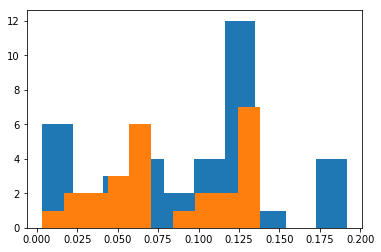

In [93]:
import matplotlib.pyplot as plt
plt.hist(overlapSig['Not-Alpha'])
plt.hist(overlapSig['Beta'])

In [92]:
overlapBC

[[u'XOR', 144, 0.001845984752951974],
 [u'XOR', 149, 3.6042111749129535e-06],
 [u'XOR', 150, 0.6556902827629288],
 [u'Row', 163, 0.012143680519292837],
 [u'XOR', 183, 3.2414657119626936e-06],
 [u'Cluster', 185, 0.1316334253316773],
 [u'Row', 200, 0.029830978803379968],
 [u'Cluster', 268, 0.017944054806149714],
 [u'XOR', 286, 2.3673002624799113],
 [u'XOR', 312, 0.25287188145580486],
 [u'Row', 314, 0.0037381584079229637],
 [u'XOR', 318, 0.027115216315940077],
 [u'Cluster', 338, 0.00818531075617699],
 [u'Row', 352, 0.02087640643355201],
 [u'XOR', 402, 1.9966635265874726],
 [u'Row', 404, 0.11484113484281792],
 [u'Cluster', 405, 0.5073601130755924],
 [u'Cluster', 408, 0.27978764457866423],
 [u'XOR', 426, 0.471580819211199]]